##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## 설정

### 모듈 구성 및 임포트

In [2]:
# 현재 경로에 있는 폴더 또는 파일명

import os
for file in os.listdir(os.getcwd()):
   print(file)

.config
sample_data


In [37]:
# 배열 csv로 저장

import numpy as np

array = [[1,2,3]]
np.savetxt('file.csv', array, delimiter=',') # delimiter 기준으로 단위를 끊음

In [43]:
# csv 배열로 가져오기

import csv

with open('file.csv', 'r', newline='\n') as file: # newline은 파일을 읽고 쓸 때 줄바꿈 처리 방법을 나타냄. \n, \r, \r\n, None 중 하나
  reader = csv.reader(file, delimiter=',')
  for rows in reader:
    print(rows)

['1.000000000000000000e+00', '2.000000000000000000e+00', '3.000000000000000000e+00']


In [44]:
# csv pandas 객체로 가져오기

import pandas as pd
data = pd.read_csv('file.csv')

data.head()

,1.000000000000000000e+00,2.000000000000000000e+00,3.000000000000000000e+00


In [ ]:
import tensorflow as tf
#✅ 글카 없는 사람: 아래 세줄 & 아래 블럭 주석처리
from numba import cuda 
device = cuda.get_current_device()
device.reset()

'\nfrom numba import cuda \ndevice = cuda.get_current_device()\ndevice.reset()\n'

In [ ]:
tf.debugging.set_log_device_placement(False)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
 except RuntimeError as e:
    # 프로그램 시작 시 메모리 증가 설정
    print(e)

"\ntf.debugging.set_log_device_placement(False)\n\ngpus = tf.config.experimental.list_physical_devices('GPU')\nif gpus:\n  try:\n    tf.config.experimental.set_memory_growth(gpus[0], True)\n except RuntimeError as e:\n    # 프로그램 시작 시 메모리 증가 설정\n    print(e)\n"

In [ ]:
from google.colab import drive
drive.mount('/content/drive') #✅1) 이 경로도 통일해야할듯 ✅2) 매번 mount 시 authorization code 복붙해야 하는거 자동화 HOW?

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')

In [ ]:
# 변수 정의
count = 5    #변환할 이미지 개수 + 1
temp_num = 1 #변환할 이미지 서수(몇번째)
content_path = f'/content/drive/MyDrive/GAN/eagle-attack-{temp_num}.png' #✅ 경로 문자열 ''|"" 종류 통일 필요
style_path = '/content/drive/MyDrive/GAN/crater.jpg'
threshold = 160 #배경 제거 시 사용할 임계값

In [ ]:
# 변환 대상 이미지 경로 list 생성
image_list = []

for i in range(1, count):
  content_name = f'/content/drive/MyDrive/GAN/eagle-attack-{i}.png'
  image_list.append(content_name)

image_list

['/content/drive/MyDrive/GAN/eagle-attack-1.png',
 '/content/drive/MyDrive/GAN/eagle-attack-2.png',
 '/content/drive/MyDrive/GAN/eagle-attack-3.png',
 '/content/drive/MyDrive/GAN/eagle-attack-4.png']

## 입력 시각화

이미지를 불러오는 함수를 정의하고, 최대 이미지 크기를 512개의 픽셀로 제한합니다.

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

이미지를 출력하기 위한 간단한 함수를 정의합니다:

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

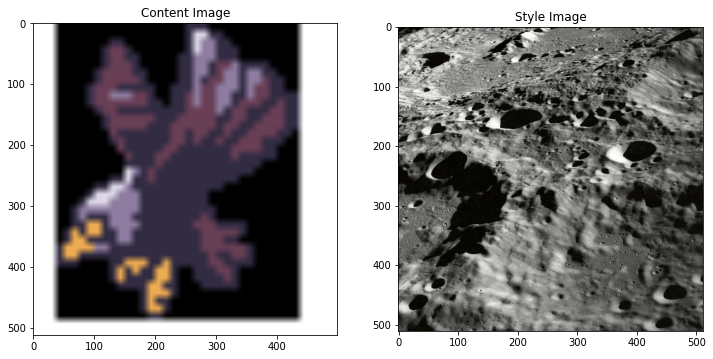

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## 콘텐츠와 스타일 표현 정의하기

이미지의 콘텐츠와 스타일 표현(representation)을 얻기 위해 모델의 몇 가지 중간층들을 살펴봅니다. <br>
모델의 입력층부터 시작해서 처음 몇 개의 층은 선분이나 질감과 같은 이미지 내의 저차원적 특성에 반응합니다. <br>
반면, 네트워크가 깊어지면 최종 몇 개의 층은 *바퀴* 나 *눈* 과 같은 고차원적 특성들을 나타냅니다. <br>
Base Model은 사전학습된 이미지 분류 네트워크인 VGG19 네트워크의 구조를 사용합니다. <br>
이 중간층들은 이미지에서 콘텐츠와 스타일 표현을 정의하는 데 필요합니다.<br>
입력 이미지가 주어졌을 때, 스타일 전이 알고리즘은 이 중간층들에서 콘텐츠와 스타일에 해당하는 타깃 표현들을 일치시켜 나갈 것입니다.


In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

[VGG19](https://keras.io/applications/#vgg19) 모델을 불러오고 작동 여부를 확인하기 위해 이미지에 적용시켜봅니다.

In [ ]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('Windsor_tie', 0.2345336),
 ('pick', 0.04721723),
 ('maraca', 0.043348018),
 ('web_site', 0.033956435),
 ('whistle', 0.031025203)]

이제 분류층을 제외한 `VGG19` 모델을 불러오고 각 층의 이름을 출력해봅니다.

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_6
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


이미지의 스타일과 콘텐츠를 나타내기 위한 모델의 중간층들을 선택합니다.

In [ ]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

### 스타일과 콘텐츠를 위한 중간층

사전훈련된 이미지 분류 네트워크 속에 있는 중간 출력으로 어떻게 스타일과 콘텐츠 표현을 정의할 수 있을까요?

고수준에서 보면 이미지 분류(네트워크의 훈련 목적)를 수행하기 위해서는 네트워크가 반드시 이미지를 이해하여야 합니다. 이 과정에는 미가공 이미지를 입력으로 받아 픽셀값들을 이미지 내 특성(feature)들에 대한 복합적인 이해로 변환할 수 있는 내부 표현(internal representation)을 만드는 작업이 포함됩니다. 또한 왜 합성곱(convolutional) 신경망의 일반화(generalize)가 쉽게 가능한지를 알 수 있습니다. 합성곱 신경망은 배경잡음(background noise)과 기타잡음(nuisances)에 상관없이(고양이와 강아지처럼 - ✅무슨 뜻이지?) 클래스 안에 있는 불변성(invariance)과 특징을 포착할 수 있습니다.

따라서 모델은 미가공 이미지의 입력과 분류 레이블(label)의 출력 중간에서 복합 특성(complex feature) 추출기의 역할을 수행합니다. <br>
그러므로 모델의 중간층에 접근함으로써 입력 이미지의 콘텐츠와 스타일을 추출할 수 있습니다.

## 모델 만들기 

`tf.keras.applications`에서 제공하는 모델들은 keras 함수형 API를 통해 중간층에 쉽게 접근할 수 있습니다.

함수형 API를 이용해 모델을 정의하기 위해 모델의 입력 및 출력을 지정합니다.

`model = Model(inputs, outputs)`

아래 함수는 중간층들의 결과물을 배열 형태로 출력하는 `VGG19` 모델을 반환합니다.

In [ ]:
""" 중간층의 출력값을 배열로 반환하는 vgg 모델 반환"""
def vgg_layers(layer_names):
  # 이미지넷 데이터셋에 사전학습된 VGG 모델을 불러옵니다
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

위 함수를 이용해 모델을 만듭니다.

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

# 각 층의 출력에 대한 통계량을 살펴봅니다
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  크기: ", output.numpy().shape)
  print("  최솟값: ", output.numpy().min())
  print("  최댓값: ", output.numpy().max())
  print("  평균: ", output.numpy().mean())
  print()

block1_conv1
  크기:  (1, 511, 511, 64)
  최솟값:  0.0
  최댓값:  852.88654
  평균:  22.835361

block2_conv1
  크기:  (1, 255, 255, 128)
  최솟값:  0.0
  최댓값:  4642.739
  평균:  150.17676

block3_conv1
  크기:  (1, 127, 127, 256)
  최솟값:  0.0
  최댓값:  7991.267
  평균:  140.56697

block4_conv1
  크기:  (1, 63, 63, 512)
  최솟값:  0.0
  최댓값:  16568.602
  평균:  543.5419

block5_conv1
  크기:  (1, 31, 31, 512)
  최솟값:  0.0
  최댓값:  1979.4775
  평균:  36.24165



## 스타일 계산하기

이미지의 콘텐츠는 중간층들의 특성 맵(feature map)의 값들로 표현됩니다.

이미지의 스타일은 각 특성 맵의 평균과 피쳐맵들 사이의 상관관계로 설명할 수 있습니다. 이런 정보를 담고 있는 `그람 행렬`(Gram matrix)은 각 위치에서 특성 벡터(feature vector)끼리의 외적을 구한 후,평균값을 냄으로써 구할 수 있습니다. 주어진 층에 대한 그람 행렬은 다음과 같이 계산할 수 있습니다.

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

이 식은 `tf.linalg.einsum` 함수를 통해 쉽게 계산할 수 있습니다

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## 스타일과 콘텐츠 추출하기


스타일과 콘텐츠 텐서를 반환하는 모델을 만듭니다.

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False


  def call(self, inputs):
    '''[0,1] 사이의 실수 값을 입력으로 받습니다'''
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

이 모델은 이미지가 입력으로 주어졌을때 `style_layers`의 스타일과 `content_layers`의 콘텐츠에 대한 그람 행렬을 출력합니다.

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

print('스타일:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())
  print()

print("콘텐츠:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())


스타일:
   block1_conv1
    크기:  (1, 64, 64)
    최솟값:  0.0
    최댓값:  48227.617
    평균:  466.33942

   block2_conv1
    크기:  (1, 128, 128)
    최솟값:  0.0
    최댓값:  95349.04
    평균:  10226.751

   block3_conv1
    크기:  (1, 256, 256)
    최솟값:  0.0
    최댓값:  345177.88
    평균:  9168.254

   block4_conv1
    크기:  (1, 512, 512)
    최솟값:  0.0
    최댓값:  3330084.5
    평균:  145623.89

   block5_conv1
    크기:  (1, 512, 512)
    최솟값:  0.0
    최댓값:  56429.086
    평균:  688.26526

콘텐츠:
   block5_conv2
    크기:  (1, 31, 31, 512)
    최솟값:  0.0
    최댓값:  783.663
    평균:  8.347081


## 경사하강법 실행

이제 스타일과 콘텐츠 추출기를 사용해 스타일 전이 알고리즘을 구현할 차례입니다. 

타깃에 대한 입력 이미지의 평균 제곱 오차를 계산한 후, 오차값들의 가중합을 구합니다.

스타일과 콘텐츠의 타깃값을 지정합니다.

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

최적화 시킬 이미지를 담을 `tf.Variable`을 정의하고 콘텐츠 이미지로 초기화합니다.(※ `tf.Variable`과 콘텐츠 이미지는 동일 size)

In [ ]:
image = tf.Variable(content_image)

픽셀 값이 실수이므로 0과 1 사이로 클리핑하는 함수를 정의합니다.

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

옵티마이저를 생성합니다. 참조 연구에서는 LBFGS를 추천하지만, `Adam`도 충분히 적합합니다.

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

최적화를 진행하기 위해 전체 오차를 콘텐츠와 스타일 오차의 가중합으로 정의합니다.

In [ ]:
style_weight=1e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

`tf.GradientTape`를 사용해 이미지를 업데이트합니다.

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

## 총 변위 손실

이 기본 구현 방식의 한 가지 단점은 많은 고주파 아티팩(high frequency artifact)가 생겨난다는 점입니다. 

아티팩 생성을 줄이기 위해서는 이미지의 고주파 구성 요소에 대한 regularization 항을 추가해야 합니다. 스타일 전이에서는 이 변형된 오차값을 *총 변위 손실(total variation loss)*라고 합니다.

In [ ]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

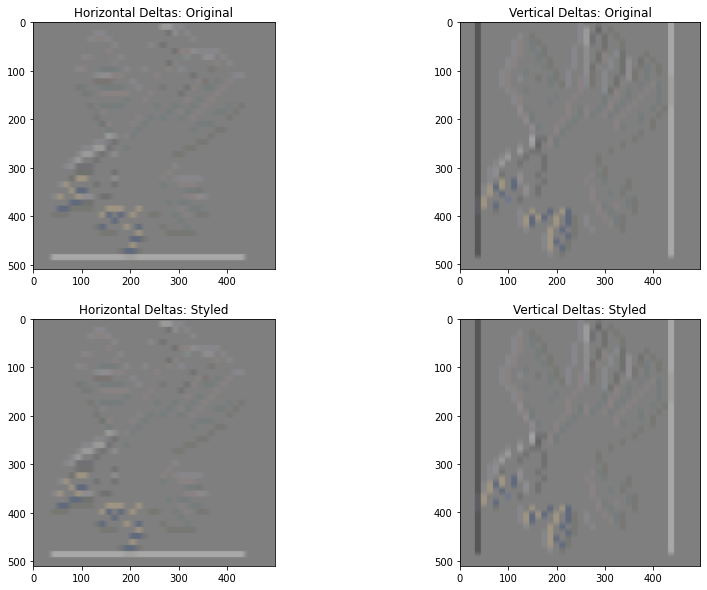

In [ ]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

위 이미지들은 고주파 구성 요소가 늘어났다는 것을 보여줍니다.

한 가지 흥미로운 사실은 고주파 구성 요소가 edge detector의 일종이라는 점입니다. 이를테면 Sobel edge detector를 사용하여 유사한 출력을 얻을 수 있습니다:

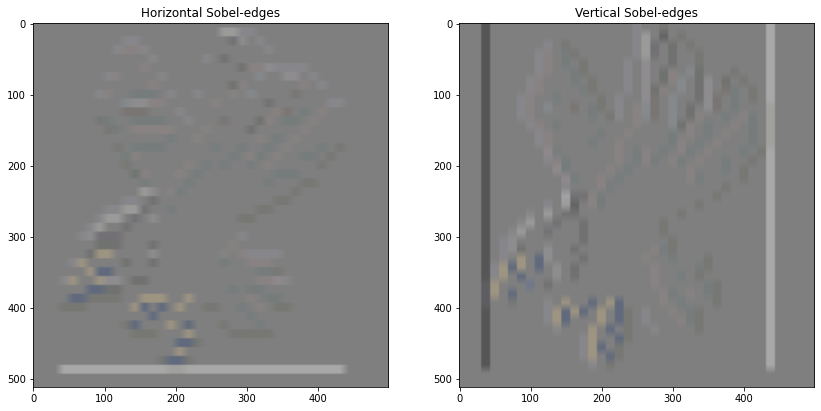

In [ ]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

정규화 오차는 각 값의 절대값의 합으로 표현됩니다.

In [ ]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [ ]:
total_variation_loss(image).numpy()

8977.379

식이 잘 계산된다는 것을 확인할 수 있습니다. Tensorflow에는 이미 표준 함수가 내장되어 있으므로 직접 오차식을 구현할 필요는 없습니다.

In [ ]:
tf.image.total_variation(image).numpy()

array([8977.379], dtype=float32)

## 다시 최적화하기

`total_variation_loss`를 위한 가중치를 정의합니다.

In [ ]:
total_variation_weight=30

이 가중치를 `train_step` 함수에 사용합니다.

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

최적화할 변수를 다시 초기화합니다.

In [ ]:
image = tf.Variable(content_image)

최적화를 수행합니다.

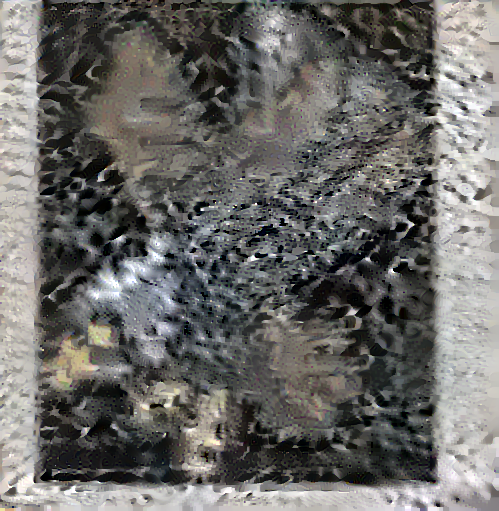

훈련 스텝: 1000
전체 소요 시간: 88.3


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("훈련 스텝: {}".format(step))

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))

최적화 결과물을 저장합니다.

In [ ]:
# ✅로컬 디렉토리에 저장 - tensor object는 opencv로 drive에 바로 저장 불가?
file_name = f'stylized-image{temp_num}.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 배경 제거하기

opencv 라이브러리를 활용하여 기존 이미지로 만든 mask로 최적화된 이미지의 배경을 제거합니다.

(512, 512)


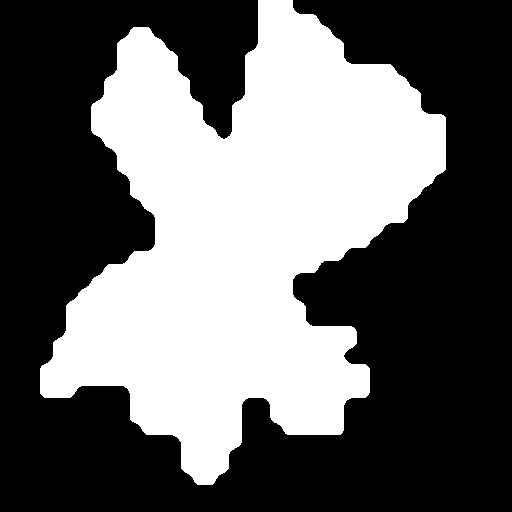

In [ ]:
# mask 만들기
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread(f"/content/drive/MyDrive/GAN/eagle-attack-{temp_num}.png",cv2.IMREAD_UNCHANGED)
img2gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img2gray = cv2.resize(img, dsize=(512,512))
# channel 3: 픽셀 값이 threshold 값("변수 정의"에서 초기화)보다 크면 255로, 아니면 0으로
_, mask = cv2.threshold(img2gray[:,:,3], threshold, 255, cv2.THRESH_BINARY) # ✅1) 3번 채널's 0,1,2 index별 mask 결과가 다른 것인지? 
                                                                            # ✅2) 기존 content image의 B.G 색상이 B냐 W인지 판정 -> THRESH_BINARY or THRESH_BINARY_INV 적용 필요(채널 index에 따라서도 다른듯?)
# mask 확인
print(mask.shape)
cv2_imshow(mask)

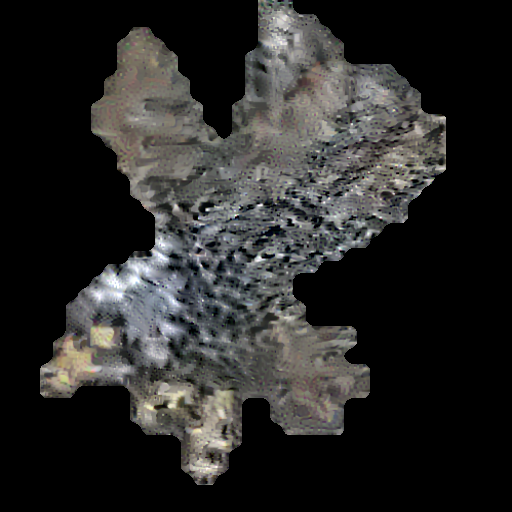

True

In [ ]:
# transformed에 mask 적용
stylized = cv2.imread(f"/content/drive/MyDrive/GAN/stylized-image{temp_num}.png")
stylized = cv2.resize(stylized, dsize=(512,512)) #✅ size 통일시키기 - 사진 크기에 따른 자동화 필요
stylized = cv2.bitwise_and(stylized, stylized, mask=mask)

# 최종 결과 확인 및 드라이브에 저장 - ✅ local에도 저장하고 싶은데 색이 변함.. 해결 HOW?
cv2_imshow(stylized)
cv2.imwrite(f"/content/drive/MyDrive/GAN/result{temp_num}.png",stylized)